# CIFAR10 using CutOut Augmentation

## Import

In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


## Import CIFAR10

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

num_train, img_channels, img_rows, img_cols =  train_features.shape

num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 12s 0us/step


## Examine the Data

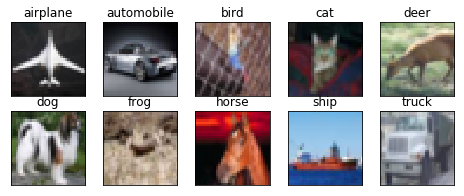

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [5]:
print(train_features.shape)
print(test_features.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Utilities

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Standardize the inputs

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Define the Model

In [9]:
# Define the model
model = Sequential()

model.add(Conv2D(48, (3, 3), padding='same', input_shape=(32, 32, 3))) # 32x32 due to padding 'same', GRF:3
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3))) #30x30 GRF:5
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) # 15x15 GRF:10
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3), padding='same')) #15x15, due to padding 'same', GRF:12
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(96, (3, 3))) #13x13, GRF:14
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) #6x6 GRF:28
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(192, (3, 3), padding='same')) #6x6, GRF:30
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(192, (3, 3))) #4x4, GRF:32
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.25))

# reduce the volume to number of classes
model.add(Conv2D(192, (3,3))) #2x2
model.add(Conv2D(96, (2,2)))  #1x1
model.add(Conv2D(num_classes, (1,1))) #1x1
model.add(GlobalAveragePooling2D())   # GAP layer
model.add(Activation('softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 48)        192       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)       

## Cutout Augmentation

[Cutout Augmentaton code from github](https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py)


In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


## Traning

In [0]:
num_epochs = 50

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  del sys.path[0]


Epoch 1/50
390/390 [==============================] - 35s 89ms/step - loss: 1.6501 - acc: 0.4356 - val_loss: 1.4046 - val_acc: 0.5187
Epoch 2/50
390/390 [==============================] - 30s 77ms/step - loss: 1.1631 - acc: 0.5858 - val_loss: 0.9937 - val_acc: 0.6493
Epoch 3/50
390/390 [==============================] - 30s 76ms/step - loss: 0.9694 - acc: 0.6590 - val_loss: 0.9400 - val_acc: 0.6764
Epoch 4/50
390/390 [==============================] - 30s 77ms/step - loss: 0.8658 - acc: 0.6952 - val_loss: 1.0340 - val_acc: 0.6537
Epoch 5/50
390/390 [==============================] - 30s 77ms/step - loss: 0.7795 - acc: 0.7259 - val_loss: 0.8196 - val_acc: 0.7236
Epoch 6/50
390/390 [==============================] - 30s 77ms/step - loss: 0.7255 - acc: 0.7448 - val_loss: 0.8021 - val_acc: 0.7341
Epoch 7/50
390/390 [==============================] - 30s 77ms/step - loss: 0.6702 - acc: 0.7655 - val_loss: 0.6441 - val_acc: 0.7781
Epoch 8/50
390/390 [==============================] - 30s 77ms

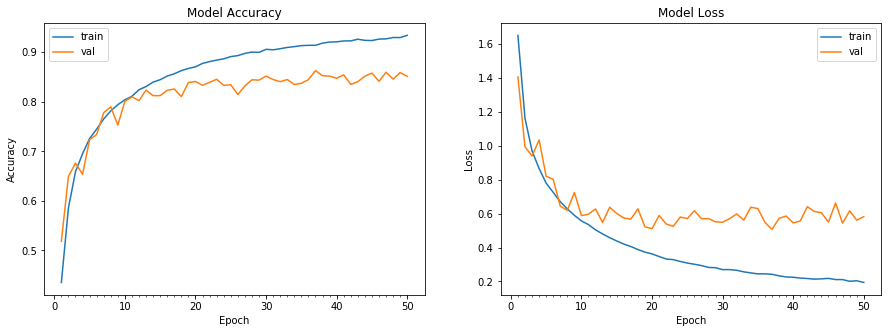

Accuracy on test data is: 85.16


In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = num_epochs, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Save the Model

In [0]:
model.save('/content/best_cutout_cifar10.hdf5')

## Predict

In [0]:
pred = model.predict(test_features)

In [0]:
pred = np.argmax(pred, axis=1)

In [17]:
pred[0:5]

array([3, 8, 8, 0, 6])

In [0]:
test_labels_act = np.argmax(test_labels, axis=1)

### Collect Metrics

In [0]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(test_labels_act, pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.86      0.86      0.86      1000
  automobile       0.92      0.94      0.93      1000
        bird       0.86      0.76      0.81      1000
         cat       0.74      0.70      0.72      1000
        deer       0.84      0.84      0.84      1000
         dog       0.76      0.82      0.79      1000
        frog       0.92      0.85      0.88      1000
       horse       0.90      0.90      0.90      1000
        ship       0.88      0.92      0.90      1000
       truck       0.85      0.93      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### Collect failure list

In [0]:
fail_list = []
for i in range(0, len(test_labels_act)):
  if test_labels_act[i] != pred[i]:
    fail_list.append(i)

In [22]:
len(fail_list)

1484

In [23]:
fail_list[0:5]

[10, 15, 32, 35, 37]

### Store few failing images

In [0]:
!rm -rf '/content/fail_images'
!mkdir '/content/fail_images'

In [0]:
?plt.imsave

In [0]:
for i in range(0, 5):
  fail_id = fail_list[i]
  fail_img = test_features[fail_id]
  actual_class_name = class_names[test_labels_act[fail_id]]
  pred_class_name = class_names[pred[fail_id]]
  file_name = '%d_act_%s_pred_%s.png' %(i, actual_class_name, pred_class_name)
  plt.imsave('/content/fail_images/'+file_name, fail_img)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/best_cutout_cifar10.hdf5' '/content/drive/My Drive/App/EVA/Session8_9/'
#!cp -r '/content/fail_images' '/content/drive/My Drive/App/EVA/Session8_9/'

In [0]:
# look at the same image from old run to compare how cutout faired.
old_fail_list = [5, 24, 35, 47, 52]

## Visualize the failures using GradCAM

[GradCAM blog](https://www.hackevolve.com/where-cnn-is-looking-grad-cam/)

In [0]:
import keras.backend as K
import cv2

In [0]:
# get gradient weighted class activation map
# inputs: image, 
#         pred_class 
#         the layer to look at for class activation maps
#         and num of channels in that layer
#
def get_GradCAM(img, pred_class, layerNameForCAM, num_channel):
  #get the conv layer
  last_conv_layer = model.get_layer(layerNameForCAM)
  
  class_output = model.output[:, pred_class]
  
  # get the gradients
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  
  x = np.expand_dims(img, axis=0)
  
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  for i in range(num_channel):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  return conv_layer_output_value

In [0]:
?cv2.cvtColor

In [0]:
def get_heat_map(img, conv_layer_output_value):
  ## heatmap
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  return heatmap
  
  

In [0]:
?cv2.imwrite

In [0]:
!mkdir '/content/cutout_grad_cam_images'

In [0]:
def get_superimposed_img(img1, img2):
  superimposed_img = cv2.addWeighted(img1, 0.7, img2, 0.3, 0, dtype= cv2.CV_8U)
  alpha = 1
  beta = 0.3
  gamma = 0
  #print(dst.shape)
  #superimposed_img = img*alpha + heatmap*beta + gamma
  #return np.array(superimposed_img, dtype=np.uint8)
  #superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  
  return superimposed_img
   

def get_superimposed_img_cv(img1, img2, index):
  img1_cv = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
  img2_cv = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
  superimposed_img = cv2.addWeighted(img1_cv, 0.7, img2_cv, 0.3, 0, dtype= cv2.CV_8U)
  alpha = 1
  beta = 0.3
  gamma = 0
  #print(dst.shape)
  #superimposed_img = img*alpha + heatmap*beta + gamma
  #return np.array(superimposed_img, dtype=np.uint8)
  dir = '/content/grad_cam_images'
  filename = '%s/%d.png' %(dir, index)
  cv2.imwrite(filename, superimposed_img)

  superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  
  return superimposed_img
   

In [0]:
?plt.subplot

In [0]:
def display_images_side_by_side(img, actual_name, heatmap_img, pred_name):
  fig, axes = plt.subplots(1,2, figsize=(10,10))
  axes[0].imshow(img)
  axes[0].set_title('Actual: ' + actual_name)
  
  axes[1].imshow(heatmap_img)
  axes[1].set_title('Pred: ' + pred_name)
  plt.show()

### Display few failures

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
?cv2_imshow

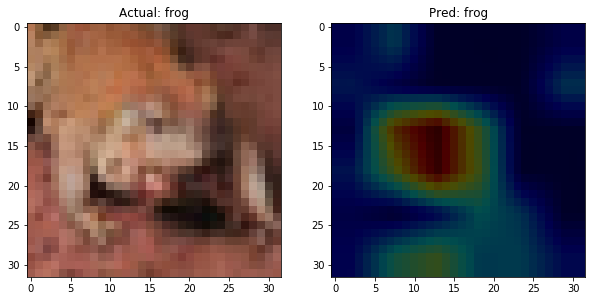

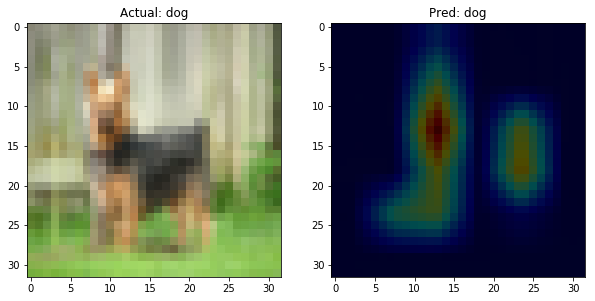

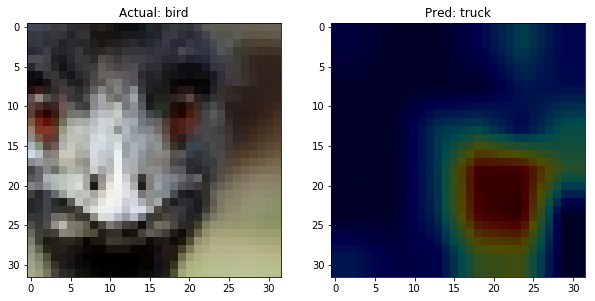

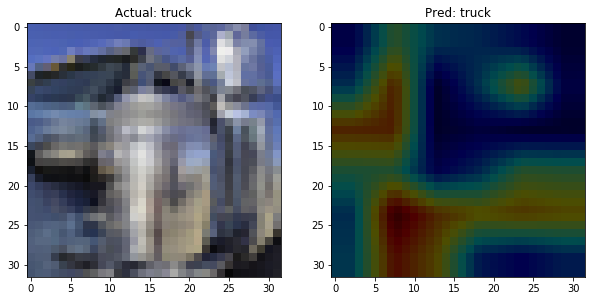

In [38]:
layer_name = 'conv2d_5'
num_channels = 192

#layer_name = 'conv2d_22'
#num_channels = 96

#layer_name = 'conv2d_24'
#num_channels = 192

# go over 4 failures
for i in range(0,4):
  
  # use old failure list to compare how cutout aug faired.
  fail_id = old_fail_list[i]
  
  # collect the info about the failing image
  fail_img = test_features[fail_id]
  actual_class_name = class_names[test_labels_act[fail_id]]
  pred_class_name = class_names[pred[fail_id]]
  pred_class = pred[fail_id]
  
  #get gradient weighted CAM
  grad_weighted_conv_out = get_GradCAM(fail_img, pred_class, layer_name, num_channels)
  
  heatmap_img = get_heat_map(fail_img, grad_weighted_conv_out)
   
  super_imposed_img = get_superimposed_img_cv(fail_img, heatmap_img, i)
  #cv2_imshow(super_imposed_img)
  
  display_images_side_by_side(fail_img, actual_class_name, 
                             super_imposed_img, pred_class_name)

In [0]:
#!cp -r '/content/cutout_grad_cam_images' '/content/drive/My Drive/App/EVA/Session8_9/'

## Summary

Out of the first four failures in the old run without any augmentation - **three of them classified CORRECTLY with CutOut Augmentation.**